# Kitchenware Classifier

In [1]:
from fastai.vision.all import *
from torch import device

## Load data and set variables

In [2]:
SEED = 42
set_seed(42)

PROJECT_DIR = Path('kitchenware_classifier')
DATA_DIR = PROJECT_DIR / 'data'
IMG_DIR = DATA_DIR / 'images'

TRAIN_DF = pd.read_csv(DATA_DIR / 'train.csv')
TEST_DF = pd.read_csv(DATA_DIR / 'test.csv')
TRAIN_DF['image'] = TRAIN_DF['Id'].map(lambda x: f'{x:0>4}.jpg')
TEST_DF['image'] = TEST_DF['Id'].map(lambda x: f'{IMG_DIR}/{x:0>4}.jpg')

In [3]:
display(TRAIN_DF.head())
display(TEST_DF.head())

,Id,label,image
0,560,glass,0560.jpg
1,4675,cup,4675.jpg
2,875,glass,0875.jpg
3,4436,spoon,4436.jpg
4,8265,plate,8265.jpg


,Id,image
0,678,kitchenware_classifier/data/images/0678.jpg
1,3962,kitchenware_classifier/data/images/3962.jpg
2,9271,kitchenware_classifier/data/images/9271.jpg
3,5133,kitchenware_classifier/data/images/5133.jpg
4,8842,kitchenware_classifier/data/images/8842.jpg


## Data Augmentations

In [4]:
tfms = aug_transforms(
    min_zoom=1.0,
    max_zoom=1.1,
    max_lighting=0.2,
    max_warp=0.2,
    p_affine=0.75,
    p_lighting=0.75,
    size=224,
)

## Build data loaders

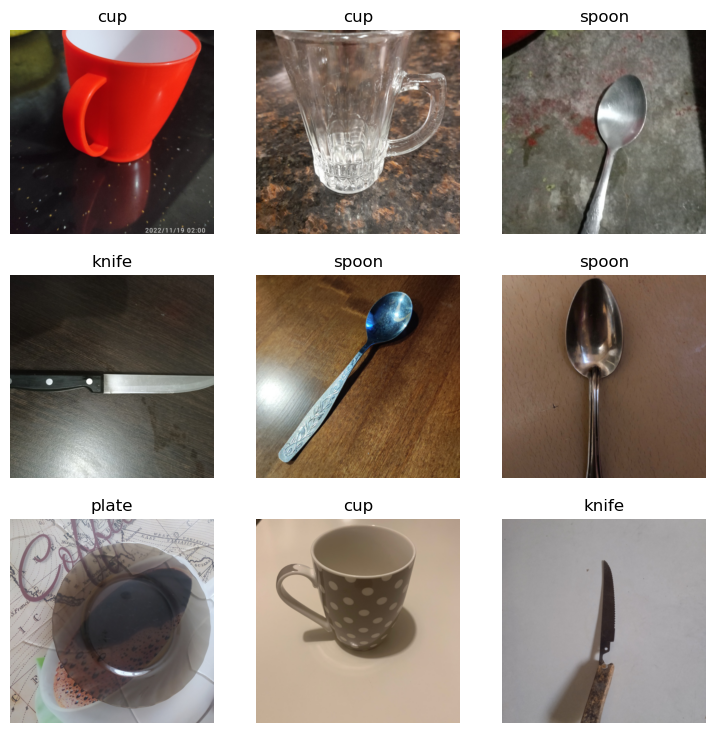

In [5]:
dls = ImageDataLoaders.from_df(
    TRAIN_DF,
    path=str(IMG_DIR),
    valid_pct=0.2,
    seed=42,
    bs=16,
    val_bs=16,
    fn_col='image',
    shuffle=True,
    label_col='label',
    item_tfms=Resize(480),
    batch_ftms=list(tfms),
    device=device('cuda'),
)
dls.show_batch()

## Build learner

In [6]:
learn = vision_learner(
    dls,
    'convnext_nano',
    metrics=[error_rate, accuracy],
    path='.',
)
keep_path = learn.path
learn.path = DATA_DIR
learn.fit_one_cycle(
    10,
    cbs=[
        EarlyStoppingCallback(
            monitor='error_rate',
            min_delta=0.000001,
            patience=3,
        ),
        SaveModelCallback(
            monitor='accuracy',
            min_delta=0.000001,
        )
    ]
)
learn.path = keep_path

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.581593,0.175195,0.055806,0.944194,01:34
1,0.324114,0.119675,0.032403,0.967597,01:35
2,0.248002,0.098019,0.030603,0.969397,01:35
3,0.225841,0.118094,0.041404,0.958596,01:34
4,0.166692,0.084476,0.031503,0.968497,01:35
5,0.163376,0.092748,0.026103,0.973897,01:35
6,0.105300,0.081516,0.026103,0.973897,01:36
7,0.094672,0.084935,0.026103,0.973897,01:36
8,0.088785,0.073528,0.020702,0.979298,01:36
9,0.061967,0.076954,0.023402,0.976598,01:36


Better model found at epoch 0 with accuracy value: 0.9441944360733032.
Better model found at epoch 1 with accuracy value: 0.9675967693328857.
Better model found at epoch 2 with accuracy value: 0.9693969488143921.
Better model found at epoch 5 with accuracy value: 0.973897397518158.
Better model found at epoch 8 with accuracy value: 0.979297935962677.


In [7]:
learn.validate()

(#3) [0.07352811098098755,0.020702069625258446,0.979297935962677]

## Find optimal learning rate

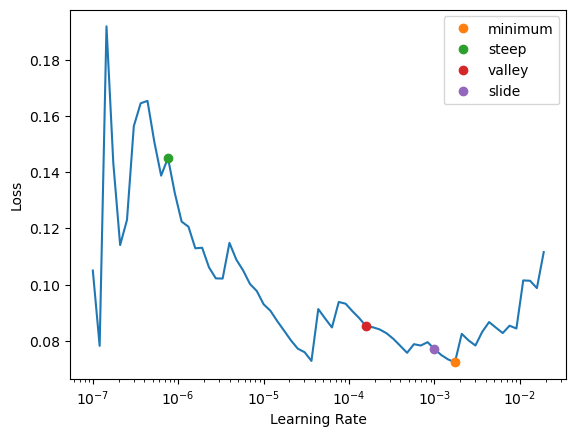

In [8]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [9]:
lrs.valley

0.00015848931798245758

## Fine tune the model

In [10]:
learn.fine_tune(12, lrs.valley)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.093169,0.078334,0.020702,0.979298,01:36


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.091628,0.074418,0.022502,0.977498,04:35
1,0.080743,0.077213,0.021602,0.978398,04:35
2,0.070638,0.075772,0.019802,0.980198,04:35
3,0.060191,0.072558,0.020702,0.979298,04:35
4,0.064847,0.070374,0.019802,0.980198,04:35
5,0.057611,0.073113,0.020702,0.979298,04:35
6,0.061686,0.074617,0.020702,0.979298,04:35
7,0.041408,0.071885,0.019802,0.980198,04:35
8,0.040071,0.074213,0.020702,0.979298,04:35
9,0.045358,0.076979,0.020702,0.979298,04:34


## Save the model

In [44]:
learn.export('fastai_model.pkl')

## Evaluate results

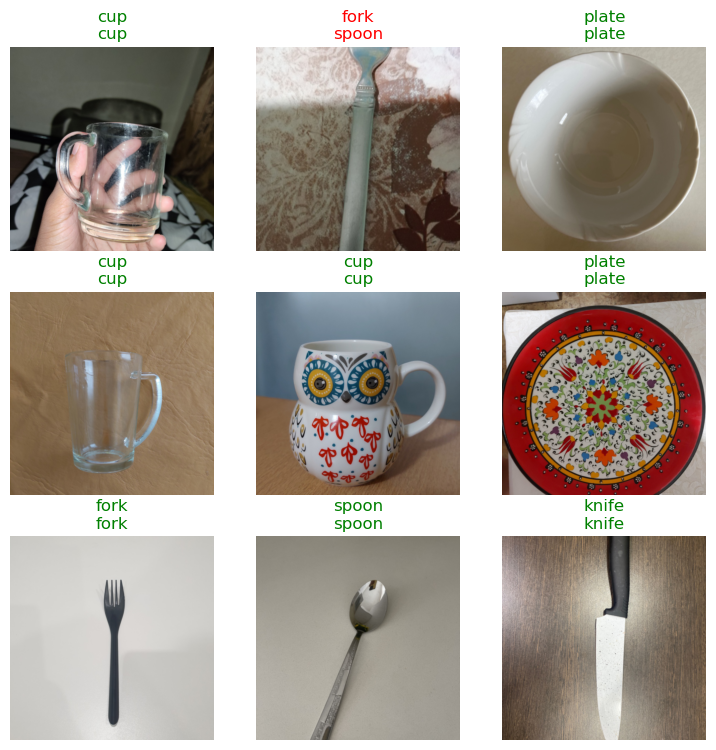

In [12]:
learn.show_results()

In [13]:
interp = Interpretation.from_learner(learn)

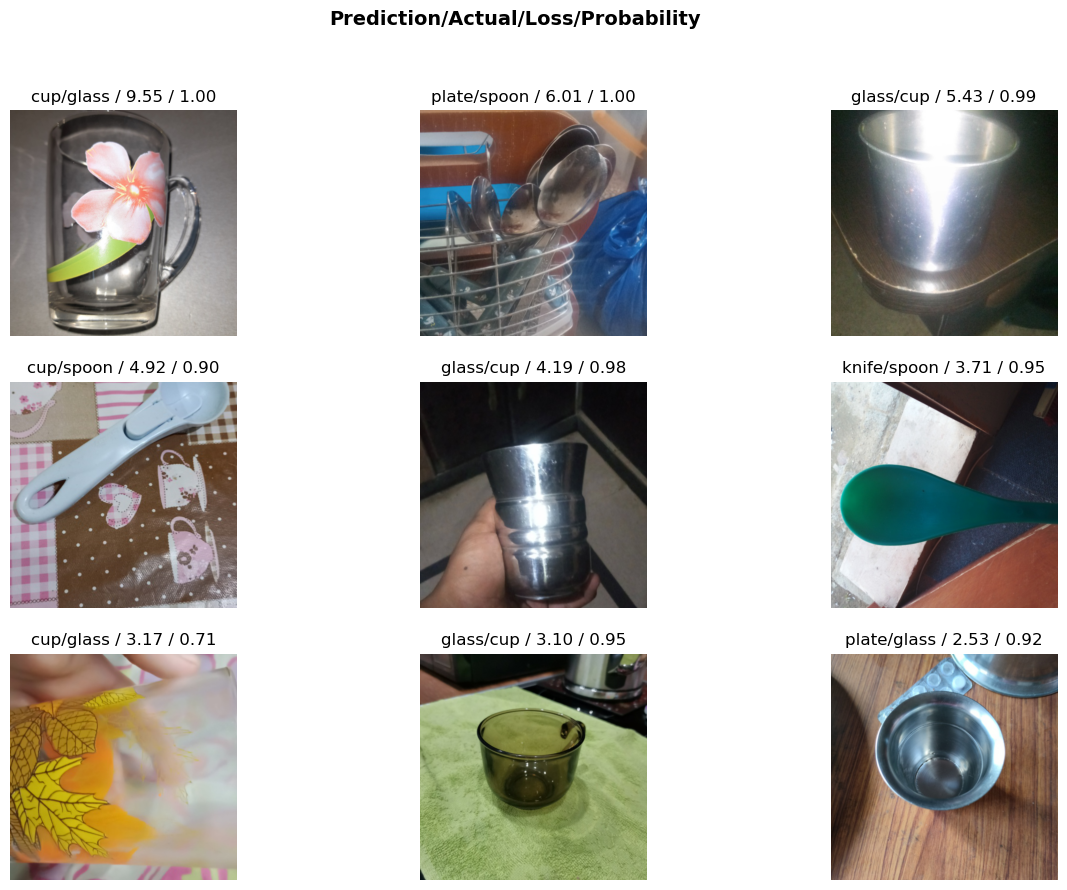

In [14]:
interp.plot_top_losses(9, figsize=(15, 10))

## Predict on testset using (TTA) Test Time Augmentation

In [15]:
tst_dl = dls.test_dl(TEST_DF.image)
tta = learn.tta(dl=tst_dl)

## Create submission file

In [16]:
tta_preds, _ = tta
idxs = tta_preds.argmax(dim=1)
vocab = np.array(dls.vocab)
sub = pd.read_csv(DATA_DIR /'test.csv')
sub['label'] = vocab[idxs]
sub.to_csv('fastai-convnext_nano-submission3.csv', index=False)
!head fastai-convnext_nano-submission.csv

head: cannot open 'fastai-convnext_nano-submission.csv' for reading: No such file or directory


In [17]:
# learn.summary()

## Save to BentoML

In [51]:
import bentoml

tag = bentoml.fastai.save_model(
    'kitchenware_fastai',
    learn,
    labels={
        "owner": "Martin Uribe",
        "email": "clamytoe@gmail.com",
        "stage": "prod",
        "version": "1.0.0",
    },
)

In [52]:
tag

Model(tag="kitchenware_fastai:lp75nrd34st2dtp6", path="/home/clamytoe/bentoml/models/kitchenware_fastai/lp75nrd34st2dtp6/")

In [20]:
model = bentoml.fastai.load_model('kitchenware_fastai')

In [21]:
model.dls